### Import Packages

In [4]:
import numpy as np 
import pandas as pd
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score

from tensorflow.python.keras.utils import np_utils
from tensorflow.python.keras.utils.vis_utils import model_to_dot
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM

In [39]:
from nltk import word_tokenize, pos_tag
from textblob import TextBlob
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords

from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity

### Clean Datasets

In [65]:
df = pd.read_csv("isear.csv", names=['emotion', 'tweet'])

In [66]:
df = df[['tweet', 'emotion']]
df

,tweet,emotion
0,Text,Emotion
1,"During the period of falling in love, each tim...",joy
2,When I was involved in a traffic accident.,fear
3,When I was driving home after several days of...,anger
4,When I lost the person who meant the most to me.,sadness
...,...,...
7469,Two years back someone invited me to be the tu...,anger
7470,I had taken the responsibility to do something...,sadness
7471,I was at home and I heard a loud sound of spit...,disgust
7472,I did not do the homework that the teacher had...,shame


In [102]:
df

,tweet,emotion
0,Text,0
1,"During the period of falling in love, each tim...",0
2,When I was involved in a traffic accident.,0
3,When I was driving home after several days of...,1
4,When I lost the person who meant the most to me.,0
...,...,...
7469,Two years back someone invited me to be the tu...,1
7470,I had taken the responsibility to do something...,0
7471,I was at home and I heard a loud sound of spit...,0
7472,I did not do the homework that the teacher had...,0


In [70]:
df['emotion'] = df['emotion'].apply(lambda x: 1 if x=='anger' else 0)

In [71]:
df2 = pd.concat([df, data2], ignore_index=True)

In [74]:
df2.emotion.value_counts()

0    11651
1     2772
Name: emotion, dtype: int64

In [481]:
emotion = ['http://saifmohammad.com/WebDocs/EmoInt%20Train%20Data/anger-ratings-0to1.train.txt', 
          'http://saifmohammad.com/WebDocs/EmoInt%20Train%20Data/joy-ratings-0to1.train.txt', 
          'http://saifmohammad.com/WebDocs/EmoInt%20Train%20Data/fear-ratings-0to1.train.txt',
            'http://saifmohammad.com/WebDocs/EmoInt%20Train%20Data/sadness-ratings-0to1.train.txt',
          'http://saifmohammad.com/WebDocs/EmoInt%20Test%20Gold%20Data/anger-ratings-0to1.test.gold.txt',
         'http://saifmohammad.com/WebDocs/EmoInt%20Test%20Gold%20Data/fear-ratings-0to1.test.gold.txt', 
          'http://saifmohammad.com/WebDocs/EmoInt%20Test%20Gold%20Data/joy-ratings-0to1.test.gold.txt', 
          'http://saifmohammad.com/WebDocs/EmoInt%20Test%20Gold%20Data/sadness-ratings-0to1.test.gold.txt', 
          'http://saifmohammad.com/WebDocs/EmoInt%20Dev%20Data%20With%20Gold/anger-ratings-0to1.dev.gold.txt',
          'http://saifmohammad.com/WebDocs/EmoInt%20Dev%20Data%20With%20Gold/fear-ratings-0to1.dev.gold.txt']

In [482]:
data = []
for i in emotion:
    df = pd.read_csv(i, sep='\t', names = ['num', 'tweet', 'emotion', 'int'])
    data.append(df)

data2 = pd.concat(data)
    

In [483]:
data2

,num,tweet,emotion,int
0,10000,How the fu*k! Who the heck! moved my fridge!.....,anger,0.938
1,10001,So my Indian Uber driver just called someone t...,anger,0.896
2,10002,@DPD_UK I asked for my parcel to be delivered ...,anger,0.896
3,10003,so ef whichever butt wipe pulled the fire alar...,anger,0.896
4,10004,Don't join @BTCare they put the phone down on ...,anger,0.896
...,...,...,...,...
105,21252,Staff on @ryainair FR1005. Asked for info and ...,fear,0.312
106,21253,Staff on @ryainair FR1005. Asked for info and ...,fear,0.271
107,21254,An adviser to the #European #Union’s top #cour...,fear,0.500
108,21255,So about 18mths ago i signed up to @Lumo_Energ...,fear,0.479


In [485]:
data2.drop_duplicates(inplace=True)

In [158]:
df2.drop(0, axis=0, inplace=True)

In [160]:
df2['tweet'] = df2.tweet.map(punc_lower)

In [179]:
df2.to_pickle('emotion.pkl')

In [7]:
def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)

In [251]:
x['tweet'] = x.tweet.apply(deEmojify)

In [8]:
data2['tweet'] = data2['tweet'].apply(deEmojify)

In [9]:
data2.drop(['num', 'int'], axis=1, inplace=True)

In [10]:
data2

,tweet,emotion
0,How the fu*k! Who the heck! moved my fridge!.....,anger
1,So my Indian Uber driver just called someone t...,anger
2,@DPD_UK I asked for my parcel to be delivered ...,anger
3,so ef whichever butt wipe pulled the fire alar...,anger
4,Don't join @BTCare they put the phone down on ...,anger
...,...,...
105,Staff on @ryainair FR1005. Asked for info and ...,fear
106,Staff on @ryainair FR1005. Asked for info and ...,fear
107,An adviser to the #European #Union’s top #cour...,fear
108,So about 18mths ago i signed up to @Lumo_Energ...,fear


In [11]:
alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())

data2['tweet'] = data2.tweet.map(alphanumeric).map(punc_lower)

In [12]:
data2['emotion'] = data2['emotion'].apply(lambda x: 1 if x=='anger' else 0)

In [512]:
new_df['text'] = new_df['text'].map(alphanumeric).map(punc_lower)

In [253]:
english = lambda x: re.sub('[^a-zA-Z]+', ' ', x)

data2['tweet'] = data2.tweet.map(english)

In [13]:
data2

,tweet,emotion
0,how the fu k who the heck moved my fridge ...,1
1,so my indian uber driver just called someone t...,1
2,dpd uk i asked for my parcel to be delivered ...,1
3,so ef whichever butt wipe pulled the fire alar...,1
4,don t join btcare they put the phone down on ...,1
...,...,...
105,staff on ryainair asked for info and told ...,0
106,staff on ryainair asked for info and told ...,0
107,an adviser to the european union’s top cour...,0
108,so about ago i signed up to lumo energy for...,0


In [14]:
data2.reset_index(inplace=True)

In [15]:
data2.drop('index', axis=1, inplace=True)

### Multinomial Naive Bayes

In [513]:
X = new_df['text']
y = new_df['emotion']

In [514]:
X_train , X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [515]:
tfidf1 = TfidfVectorizer()
emotion_df = tfidf1.fit_transform(X_train).todense()
X2_test = tfidf1.transform(X_test).todense()

In [516]:
emotion_df

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [517]:
clf = MultinomialNB()
clf.fit(emotion_df, y_train)

MultinomialNB()

In [518]:
y_pred = clf.predict(X2_test)

In [519]:
accuracy_score(y_pred, y_test)

0.7945399751817054

In [520]:
clf.score(X2_test, y_test)

0.7945399751817054

In [527]:
test = ['Please do this assignment again. You can do better.']

In [528]:
test2 = tfidf1.transform(test).todense()

In [529]:
clf.predict_proba(test2)

array([[0.80460414, 0.19539586]])

In [511]:
new_df = pd.read_pickle('semilast.pkl')

In [421]:
df30 = pd.read_pickle('final_df.pkl')

In [ ]:
df2 = pd.read_pickle('emotion.pkl')

### Get Data from Twitter

In [117]:
!pip install python-twitter

     |████████████████████████████████| 67 kB 1.4 MB/s eta 0:00:011


In [5]:
import twitter

In [6]:
api = twitter.Api(consumer_key='Insert Key',
                      consumer_secret='Insert Key',
                      access_token_key= 'Insert Token',
                      access_token_secret='Insert Secret Token')

In [509]:
happy = api.GetSearch(raw_query="q=%23happy&src=typed_query&count=100")

In [154]:
results2 = api.GetSearch(raw_query="q=%23angry&src=typed_query&count=100")

In [274]:
x = []
for i in results2:
    x.append(i.text)

for i in results:
    x.append(i.text)
    
for i in results3:
    x.append(i.text)
    
for i in results6:
    x.append(i.text)
    

In [230]:
results3 = api.GetSearch(raw_query="q=%23angry&src=typed_query&count=100")

In [270]:
results4 = api.GetSearch(raw_query="q=%23passiveaggressive&src=typed_query&count=100")

In [272]:
results6 = api.GetSearch(raw_query="q=%23angry&src=typed_query&count=100")

In [279]:
def letters(input):
    valids = []
    for character in input:
        if character.isalpha():
            valids.append(character)
    return ''.join(valids)

In [280]:
x2 = x.copy()

In [281]:
x2

''

In [283]:
emotion = pd.DataFrame(x, columns=['tweet'])

In [292]:
emotion.drop_duplicates(inplace=True)

In [299]:
remove_i = lambda x:re.sub(r'[^\x00-\x7f]',r'', x)
emotion['tweet'] = emotion.tweet.map(remove_i)

In [302]:
emotion.isna().sum()

tweet    0
dtype: int64

In [306]:
emotion.dropna()

,tweet
0,Never make a #decision when you're #angry and ...
1,@AdamsAlii This never works with my name I am ...
2,#angry doesnt even describe how I feel right n...
3,"se no tirarem a gente, participamos das prxima..."
4,"I always available in good times and bad, you ..."
...,...
387,", \nhttps://t.co/BugbAE3mKa\n#Punjab..."
388,@GregTMiraglia The more I read into it the mor...
389,@S4IWR1D youre probably the only one #sad #dis...
390,RT @therealwombat1: @katherineOma @79topper It...


In [307]:
emotion['emotion'] = 1

In [310]:
emotion.reset_index(inplace=True, drop=True)

In [ ]:
remove_i = lambda x:re.sub(r'[^\x00-\x7f]',r'', x)

In [315]:
remove_a = lambda x:re.sub("#angry", '', x)
remove_h = lambda x:re.sub("#", '', x)

In [313]:
emotion['tweet'] = emotion.tweet.map(remove_a)

In [316]:
emotion['tweet'] = emotion.tweet.map(remove_h)

In [318]:
emotion.to_pickle('angry_tweet.pkl')

In [323]:
results8 = api.GetSearch(raw_query="q=%23angry&src=typed_query&since=2014-07-19&count=100")

### Get Data from Reddit 

In [3]:
import praw

In [9]:
reddit = praw.Reddit(client_id='', client_secret='', user_agent='')


Version 7.0.0 of praw is outdated. Version 7.1.0 was released Tuesday June 23, 2020.


In [199]:
hot_posts = reddit.subreddit('angry').hot(limit=1000)
for post in hot_posts:
    print(post.title)

"I'll call you" is bullshit.
I hate my guardian
Has anyone ever lost a job because of their anger?
i'm never inviting people over again
Doctors never helped me
It’s like my life revolves around being angry!!!
I don't even know what to title my posts anymore
Fuck math
Im through.
im angry again
Whoever put the stinky and sticky paper fly trap on my bed, die in a fire
"Ok sir. Whats ur ethnicity?"
I really want to saw my phone in half
im angry ofc
IG and Misleading Hashtags
Really!?!?!?!?!?!?!?!
I hate problem that fucking say this shit.
Ugh angry wife
Suicide hotline is a fucking joke
Too much radicalism on the world
angry
i hate life
im angry
Stupid husband can’t be a damn dad
turn your gd music down!
I hate Russia and their divisive Qanon bullshit
i hate judgement
"Life doesn't owe you anything"
Stupid fucking Roblox Noobs think they're so cool
Why Can't Some People Take Responsibility?
I am fighting for mental health but people misunderstand me
r/Houston is an unfair subreddit
I just

Gamestop didn't tell me that I couldnt get my game after waiting for 6 months
Why am I being Guilt tripped
I've fucking had it with 99.999999999% of people that I know! Fucking damn it!
I've never really felt so angry until today
why did my (ex) friend think its okay to basically assult me??
How is this fair?
I give up part 2
To angry to write a good title
I’m an awful person.
I give up
What ails you, boy?
Fuck this. I'm not even gonna ask for help anymore.
Mad that people cant see your true colors
I’m at a loss. My hatred for the man whose DNA I share has exponentially expanded
Take your fucking two part authentication and fucking shove it
Angry at people in general
Must you fucking rev your engine?
F*@/%#ckk
I want to hire someone to beat the shit out of my ex brother-in-law?
Two things.
Internet access for everyone + Social Media has led to the downfall of society. (also onlyfans rant)
...
I just fucking can’t anymore.
I'll always remember this Martin guy...
Fuck you tech support sc

In [331]:
posts = []
ml_subreddit = reddit.subreddit('angry')
for post in ml_subreddit.top(limit=1000):
    posts.append([post.title, post.score, post.id, post.subreddit, post.url, post.num_comments, post.selftext, post.created])
for post in ml_subreddit.new(limit=500):
    posts.append([post.title, post.score, post.id, post.subreddit, post.url, post.num_comments, post.selftext, post.created])
for post in ml_subreddit.hot(limit=500):
    posts.append([post.title, post.score, post.id, post.subreddit, post.url, post.num_comments, post.selftext, post.created])
rant_subreddit = reddit.subreddit('rant')
for post in rant_subreddit.top(limit=1000):
    posts.append([post.title, post.score, post.id, post.subreddit, post.url, post.num_comments, post.selftext, post.created])
for post in rant_subreddit.new(limit=500):
    posts.append([post.title, post.score, post.id, post.subreddit, post.url, post.num_comments, post.selftext, post.created])
posts = pd.DataFrame(posts,columns=['title', 'score', 'id', 'subreddit', 'url', 'num_comments', 'body', 'created'])
print(posts)

                                                  title  score      id  \
0     how am i meant to build karma if they don't le...     82  92hqz4   
1     Not a single person has upvoted anything I've ...     75  gkl8hz   
2                                       GO AWAY TIK TOK     63  9sb19r   
3     The people stock buying soap and hand sanitise...     53  fi2uvb   
4     Fuck people who have kids they can’t afford to...     50  c7ikbn   
...                                                 ...    ...     ...   
3485                                 Evil people exist.      5  ikpj25   
3486                                    Braces are hell      2  ikpck2   
3487                                   From the people,      1  ikp8n1   
3488  Can't write an essay on Woodshop because it's ...      3  ikp43o   
3489               It sucks when your post gets removed      1  ikp22u   

     subreddit                                                url  \
0        angry  https://www.reddit.com/r/a

In [478]:
posts2 = []
ml2_subreddit = reddit.subreddit('happy')
for post in ml2_subreddit.top(limit=1000):
    posts2.append([post.title, post.score, post.id, post.subreddit, post.url, post.num_comments, post.selftext, post.created])
for post in ml2_subreddit.new(limit=1000):
    posts2.append([post.title, post.score, post.id, post.subreddit, post.url, post.num_comments, post.selftext, post.created])

posts2 = pd.DataFrame(posts2,columns=['title', 'score', 'id', 'subreddit', 'url', 'num_comments', 'body', 'created'])

In [479]:
posts2

,title,score,id,subreddit,url,num_comments,body,created
0,My sweet girl is CANCER FREE today!!!,85842,6yze1g,happy,https://i.redd.it/e8dskluqtrkz.jpg,1174,,1.504954e+09
1,7 years ago my ex slammed my face into a bathr...,83339,axac7r,happy,https://i.redd.it/119gf9pz85k21.jpg,2059,,1.551752e+09
2,"200 days drugs free today, on my way to my fir...",65035,afyn3l,happy,https://imgur.com/v10blf0,1700,,1.547519e+09
3,A year ago my wife left me and my girls. I fin...,60742,8xgij6,happy,https://i.imgur.com/Ytj2PYC.jpg,1236,,1.531201e+09
4,Please help me shock my husband by our picture...,56919,9eyzip,happy,https://i.redd.it/cur93aoaxml11.jpg,572,,1.536712e+09
...,...,...,...,...,...,...,...,...
1945,[Play] A teacher and student play You Are My S...,2,hnouhi,happy,/r/Guitar/comments/hn1od9/play_a_teacher_and_s...,1,,1.594269e+09
1946,Special Jam delivery with my peanut butter.,12,hnmf2i,happy,https://v.redd.it/jv06pu8reo951,1,,1.594262e+09
1947,Passed my EMT test and got full custody of my ...,5224,hnkmqj,happy,https://i.redd.it/6tkhoih6yn951.jpg,172,,1.594256e+09
1948,Single (M45) lives in cali. Found out I have t...,21,hnkkjf,happy,https://www.reddit.com/r/happy/comments/hnkkjf...,8,I have something to share as I've been looking...,1.594256e+09


In [480]:
posts2.to_pickle('happy2.pkl')

In [332]:
posts.drop_duplicates(inplace=True)

In [333]:
posts.reset_index(drop=True, inplace=True)

In [464]:
posts.to_pickle('reddit2.pkl')

In [335]:
reddit_df = posts[['title', 'body']]

In [504]:
posts3 = []
ml3_subreddit = reddit.subreddit('sad')
for post in ml3_subreddit.new(limit=500):
    posts3.append([post.title, post.score, post.id, post.subreddit, post.url, post.num_comments, post.selftext, post.created])

posts3 = pd.DataFrame(posts3,columns=['title', 'score', 'id', 'subreddit', 'url', 'num_comments', 'body', 'created'])

In [506]:
posts3.to_pickle('sad.pkl')

## Topic Modeling with TF-IDF and NMF

In [337]:
alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())

reddit_df['body'] = reddit_df.body.map(alphanumeric).map(punc_lower)

<ipython-input-337-4b571e9ed33a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reddit_df['body'] = reddit_df.body.map(alphanumeric).map(punc_lower)


In [245]:
def verb_adj(text):
    v_adj = lambda pos: pos[:2] == 'JJ' or pos[:2] == 'NN' 
    tokenized = word_tokenize(text)
    adj = [word for (word, pos) in pos_tag(tokenized) if v_adj(pos)] 
    return ' '.join(adj)

In [338]:
reddit_df['body'] = reddit_df.body.apply(verb_adj)

<ipython-input-338-a6d1873e93c3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reddit_df['body'] = reddit_df.body.apply(verb_adj)


In [65]:
lemmatizer = WordNetLemmatizer() 
def lemmatizer_tokenizer(str_input):
    words = re.sub(r"[^A-Za-z0-9\-]", " ", str_input).lower().split()
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)

In [339]:
reddit_df['body'] = reddit_df.body.apply(lemmatizer_tokenizer)


<ipython-input-339-a2a4cd570654>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reddit_df['body'] = reddit_df.body.apply(lemmatizer_tokenizer)


In [340]:
reddit_df

,title,body
0,how am i meant to build karma if they don't le...,i i cooldown wtf
1,Not a single person has upvoted anything I've ...,i such stupid pet peeve
2,GO AWAY TIK TOK,grrrrr fuck ur ad
3,The people stock buying soap and hand sanitise...,mum high risk person fucking covid vet special...
4,Fuck people who have kids they can’t afford to...,brother deepest poverty southeast u s disabled...
...,...,...
3087,Evil people exist.,people much much bad intention life i horrible...
3088,Braces are hell,everyone brace year grand scheme thing i i fee...
3089,"From the people,",people true people right kind people one
3090,Can't write an essay on Woodshop because it's ...,english favorite subject thing i t favorite ac...


In [314]:
stop_words = stopwords.words('english')
stop_words.extend(['fuck', 'fucking', 'shit', 'don', 'doesn', 'ha', 'wa', 'something', 
                   'angry', 'anger','nothing', 'thing', 'way', 'im', 'post', 'reddit', 'comment', 'much', 'cuz'])

In [341]:
tfidf1 = TfidfVectorizer(stop_words=stop_words)
reddit_df2 = tfidf1.fit_transform(reddit_df.body)

In [406]:
nmf_model = NMF(7, random_state=23)
doc_topic = nmf_model.fit_transform(reddit_df2)

In [407]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [409]:
display_topics(nmf_model, tfidf1.get_feature_names(), 12)


Topic  0
job, day, time, work, money, week, car, hour, month, home, phone, today

Topic  1
people, someone, black, everyone, person, white, reason, anyone, others, issue, lot, racist

Topic  2
friend, time, guy, relationship, girl, someone, best, year, friendship, person, day, reason

Topic  3
mom, kid, child, year, parent, dad, family, woman, school, sister, brother, mother

Topic  4
life, everything, everyone, happy, world, real, anything, hard, love, good, person, year

Topic  5
dog, cat, animal, someone, owner, roommate, grown, asshole, super, pet, stop, room

Topic  6
game, ad, video, stupid, youtube, time, xbox, console, site, minute, god, website


In [410]:
reddit_topic = pd.DataFrame(doc_topic.round(3), index=reddit_df.title)
reddit_topic

,0,1,2,3,4,5,6
title,,,,,,,
how am i meant to build karma if they don't let me post to build my karma wtf,0.000,0.002,0.000,0.002,0.003,0.005,0.000
"Not a single person has upvoted anything I've posted, And its my fucking cake day",0.002,0.002,0.000,0.000,0.000,0.014,0.034
GO AWAY TIK TOK,0.000,0.000,0.000,0.000,0.000,0.000,0.109
The people stock buying soap and hand sanitiser because of covid19 can go fuck themselves,0.016,0.088,0.000,0.000,0.000,0.001,0.005
Fuck people who have kids they can’t afford to take care of,0.003,0.009,0.000,0.209,0.028,0.000,0.000
...,...,...,...,...,...,...,...
Evil people exist.,0.000,0.071,0.066,0.000,0.129,0.000,0.000
Braces are hell,0.050,0.002,0.011,0.028,0.011,0.000,0.006
"From the people,",0.000,0.281,0.000,0.000,0.000,0.000,0.000


In [367]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
from sklearn.metrics import silhouette_score
from sklearn import metrics


In [411]:
SSEs = []
Sil_coefs = []
for k in range(2,20):
    km = KMeans(n_clusters=k, random_state=1)
    km.fit(reddit_topic)
    labels = km.labels_
    Sil_coefs.append(metrics.silhouette_score(reddit_topic, labels, metric='euclidean'))
    SSEs.append(km.inertia_) # The SSE is just inertia, we
                                            # could have just said km.inertia_

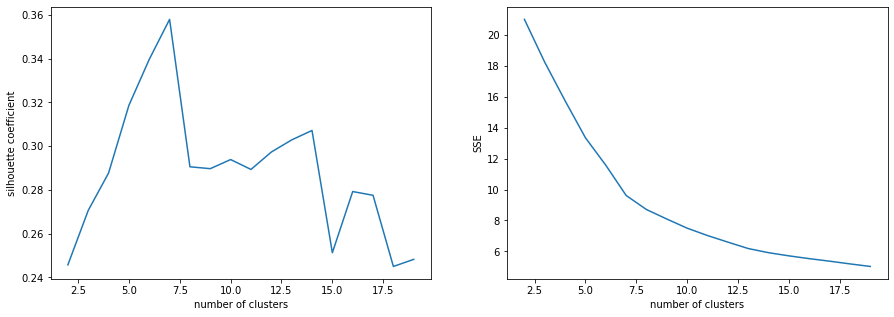

In [412]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5), sharex=True)
k_clusters = range(2,20)
ax1.plot(k_clusters, Sil_coefs)
ax1.set_xlabel('number of clusters')
ax1.set_ylabel('silhouette coefficient')

# plot here on ax2
ax2.plot(k_clusters, SSEs)
ax2.set_xlabel('number of clusters')
ax2.set_ylabel('SSE');

In [413]:
km3 = KMeans(n_clusters=7)

In [414]:
km3.fit(reddit_topic)

KMeans(n_clusters=7)

In [415]:
labels = km3.labels_

In [416]:
km3.labels_

array([0, 0, 5, ..., 2, 0, 0], dtype=int32)

In [417]:
len(labels)

3092

In [381]:
reddit_clusters = reddit_topic.copy()

In [418]:
reddit_clusters['cluster'] = labels

In [419]:
reddit_clusters.groupby('cluster').cluster.count()

cluster
0    1759
1     402
2     400
3     200
4     157
5     117
6      57
Name: cluster, dtype: int64

In [420]:
km2.cluster_centers_

array([[0.01484345, 0.01084665, 0.01279553, 0.09580831, 0.01326518,
        0.00670288, 0.0057476 , 0.01039936],
       [0.02389369, 0.01263957, 0.00616657, 0.00923195, 0.00869471,
        0.00337237, 0.0097925 , 0.00896532],
       [0.01281462, 0.10311749, 0.00954569, 0.01008877, 0.0147154 ,
        0.00255091, 0.00701305, 0.01224021],
       [0.00673276, 0.01725   , 0.0112069 , 0.01309483, 0.01250862,
        0.00280172, 0.00680172, 0.14633621],
       [0.01769481, 0.02114286, 0.14525974, 0.01376623, 0.02307143,
        0.00425325, 0.00612987, 0.01127922],
       [0.00639815, 0.01103704, 0.01524074, 0.00819444, 0.00759259,
        0.00108333, 0.16286111, 0.0037037 ],
       [0.01382178, 0.02511881, 0.01302475, 0.01422772, 0.11392574,
        0.00520792, 0.00636139, 0.00769307],
       [0.00929825, 0.01392982, 0.00992982, 0.01582456, 0.00901754,
        0.19531579, 0.00508772, 0.009     ]])